In [1]:
import numpy as np
import pandas as pd
pdidx = pd.IndexSlice
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from numpy import random as rand
from scipy import *
import time as T

from sklearn.metrics import roc_curve, roc_auc_score, log_loss, accuracy_score, precision_recall_curve,\
                            average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance


# Testing correlations

In [2]:
path_to_data = "../train.csv"
ALL_DATA = pd.read_csv(path_to_data)

In [3]:
def preprocess_PoC(df):
       
#     df = df.drop(columns=['near_price','far_price']).dropna()

    df = (df
          .set_index(['date_id','stock_id','seconds_in_bucket'])
          .sort_index(level=['date_id','stock_id','seconds_in_bucket'], sort_remaining=False))
    
    # Drop row_id and time_id, not needed for training
    df = df.drop(['row_id', 'time_id'], axis=1)
    # And, in this case, we select every 10th of each time series input
    targets = df[['target']]#.loc[pd.IndexSlice[:, :, ::10]]
    df = df.drop(['target'], axis=1)
    
    return df, targets

In [4]:
X_processed, y_processed = preprocess_PoC(ALL_DATA)
%reset_selective ALL_ASSETS

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [5]:
x_wide = X_processed.unstack('stock_id')
# x_wide

In [6]:
y_wide = y_processed['target'].unstack('stock_id')

## Target with Target

In [ ]:
cmap = 'RdBu_r'
# maybe should do target with next time step target? although i guess that should
# go linearly with target - target change correlation
# ...
# they seem to be surprisngly different, did i do something wrong?
# probably not, see markdown below for interpretation

y_forward = y_wide.groupby(level='date_id').shift(-1)
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[::4]:
    subdf = y_wide.loc[pdidx[:, dt], :]
    subdf_forward = y_forward.loc[pdidx[:, dt], :]
    cat = pd.concat([subdf, subdf_forward], axis=1, keys=['now', 'future'])
    # Calculate correlation
    corr_matrix = cat.corr().loc['now', 'future']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.6, vmax=0.6)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = subdf.shape[1]
    plt.xticks(range(0, num_stocks, 10), subdf.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), subdf.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nTarget with Target', fontsize=16, pad=20)
    plt.show()

## Target changes with Target changes

In [ ]:
# now corrected to forward difference
DY = y_wide - y_wide.groupby(level='date_id').shift(1)
cmap = 'RdBu_r'

for dt in DY.index.get_level_values('seconds_in_bucket').unique()[::4]:
    subdf_T = y_wide.loc[pdidx[:, dt], :]
    subdf_dT = DY.loc[pdidx[:, dt], :]
    # Calculate correlation
    cat = pd.concat([subdf_T, subdf_dT], axis=1, keys=['target', 'target_ch'])
    corr_matrix = cat.corr().loc['target', 'target_ch']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.6, vmax=0.6)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = DY.shape[1]
    plt.xticks(range(0, num_stocks, 10), DY.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), DY.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nTarget with Target Changes', fontsize=16, pad=20)
    plt.show()

## Comparing target - target forward correlations with target - target change correlations, it seems we see that (now after correcting for peak-forwards):
1) Both Target and Target Changes are positively correlated with itself

## Features with Target

In [ ]:
x_wide.stack().columns.unique()

In [ ]:
feature = 'wap'
# we shouldn't look at time 0 for wap because the correlation is undefined since everything is 1 anyway
wapSwitch = 0  

In [ ]:
cmap = 'RdBu_r'
y_forward = y_wide.groupby(level='date_id').shift(-1)
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[wapSwitch::4]:
    y_slice = y_forward.loc[pdidx[:, dt], :]
    x_slice = x_wide.loc[pdidx[:, dt], feature]
#     print(x_slice)
    cat = pd.concat([x_slice, y_slice], axis=1, keys=['X', 'target'])
    
    # Calculate correlation
    corr_matrix = cat.corr().loc['X', 'target']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.4, vmax=0.4)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = y_slice.shape[1]
    plt.xticks(range(0, num_stocks, 10), y_slice.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), y_slice.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nFeature: {feature}', fontsize=16, pad=20)
    plt.show()

## Features with Target changes

In [ ]:
cmap = 'RdBu_r'
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[wapSwitch::4]:
    DY_slice = DY.loc[pdidx[:, dt], :]
    x_slice = x_wide.loc[pdidx[:, dt], feature]
    cat = pd.concat([x_slice, DY_slice], axis=1, keys=['X', 'target'])
    
    # Calculate correlation
    corr_matrix = cat.corr().loc['X', 'target']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.4, vmax=0.4)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = DY_slice.shape[1]
    plt.xticks(range(0, num_stocks, 10), DY_slice.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), DY_slice.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nFeature: {feature} with Target Changes', fontsize=16, pad=20)
    plt.show()

# Predicitng next Target change direction

## One stock's target, one stock's feature

In [ ]:
## pick a stock, say...
STOCK = 167
# we'll try xgboost
# but first, let's create the data we'll need and take a looksie
#wait this actually looks into the future apparently
# DY = y_wide.groupby(level='date_id').shift(-1) - y_wide

#instead let's try
DY = y_wide - y_wide.groupby(level='date_id').shift(1)

In [ ]:
# %matplotlib notebook
full_test_data_X = x_wide.loc[pdidx[:, 520], :].xs(STOCK, level=1, axis=1)
test_data_Y = np.sign(DY.loc[pdidx[:, 520],STOCK])

up_y = test_data_Y[test_data_Y==1]
up_x = full_test_data_X.loc[up_y.index,:]
dwn_y = test_data_Y[test_data_Y==-1]
dwn_x = full_test_data_X.loc[dwn_y.index,:]

feat1 = 'near_price'
feat2 = 'far_price'
feat3 = 'imbalance_buy_sell_flag'

# x_d = dwn_x[feat1]
# if wap is an "average coordinate", below is a "relative coordinate"
x_d = (dwn_x['bid_price']*dwn_x['ask_size'] - dwn_x['ask_price']*dwn_x['bid_size'])/(dwn_x['bid_size']+dwn_x['ask_size'])
y_d = dwn_x[feat2]
z_d = dwn_x[feat3]

# x_nd = up_x[feat1]
x_nd = (up_x['bid_price']*up_x['ask_size'] - up_x['ask_price']*up_x['bid_size'])/(up_x['bid_size']+up_x['ask_size'])
y_nd = up_x[feat2]
z_nd = up_x[feat3]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_nd, y_nd, z_nd, label='went up' ,color='g')#,alpha=.1)
ax.scatter(x_d, y_d, z_d, label='went down',color='r')#,alpha=.5)

ax.legend(bbox_to_anchor=(1, 0.5), loc='upper left', frameon=False)
plt.show()

In [ ]:
%matplotlib

### seems like the relative coordiante is important

In [ ]:
# relative wap construction
bid_p = x_wide['bid_price']
ask_p = x_wide['ask_price']
bid_s = x_wide['bid_size']
ask_s = x_wide['ask_size']

rel_wap = (bid_p * ask_s - ask_p * bid_s) / (bid_s + ask_s)

new_cols = pd.MultiIndex.from_product([['relative_wap'], rel_wap.columns])
imbalance_df = pd.DataFrame(rel_wap.values, index=x_wide.index, columns=new_cols)

#historical target construction
target_lag_6 = y_wide.groupby(level=0).shift(6)
new_target_cols = pd.MultiIndex.from_product([['target_lag_6'], target_lag_6.columns])
target_lag_df = pd.DataFrame(target_lag_6.values, index=x_wide.index, columns=new_target_cols)


x_wide_new_feats = pd.concat([x_wide, imbalance_df, target_lag_df], axis=1)
# x_wide = x_wide.dropna(subset=[('target_lag_6', y_wide.columns[0])])


## now to create the model

In [ ]:
divide = 200
train_data_X = x_wide_new_feats.loc[pdidx[:divide, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
train_data_Y = np.sign(DY.loc[pdidx[:divide, :],STOCK]).values
valid_data_X = x_wide_new_feats.loc[pdidx[divide:, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
valid_data_Y = np.sign(DY.loc[pdidx[divide:, :],STOCK]).values

In [ ]:
mask_train = ~np.isnan(train_data_Y)
train_X_clean = train_data_X[mask_train].copy()
train_Y_clean = train_data_Y[mask_train].copy()

mask_valid = ~np.isnan(valid_data_Y)
valid_X_clean = valid_data_X[mask_valid].copy()
valid_Y_clean = valid_data_Y[mask_valid].copy()

train_Y_binary = (train_data_Y[mask_train] >= 0).astype(int)
valid_Y_binary = (valid_data_Y[mask_valid] >= 0).astype(int)

In [ ]:
valid_X_clean.columns

### let's try scaling the lot sizes

In [ ]:
train_X_clean['bid_size'] = np.log(train_X_clean['bid_size'])
valid_X_clean['bid_size'] = np.log(valid_X_clean['bid_size'])

train_X_clean['ask_size'] = np.log(train_X_clean['ask_size'])
valid_X_clean['ask_size'] = np.log(valid_X_clean['ask_size'])

train_X_clean['matched_size'] = np.log(train_X_clean['matched_size'])
valid_X_clean['matched_size'] = np.log(valid_X_clean['matched_size'])

train_X_clean['imbalance_size'] = np.log(train_X_clean['imbalance_size'])
#replace bad values with 0
train_X_clean['imbalance_size'] = train_X_clean['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

valid_X_clean['imbalance_size'] = np.log(valid_X_clean['imbalance_size'])
#replace bad values with 0
valid_X_clean['imbalance_size'] = valid_X_clean['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
BT = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    learning_rate=0.05,
    n_estimators=20,
    max_depth=6
)

BT.set_params(eval_metric=["auc","logloss"], early_stopping_rounds=50)


In [ ]:
BT.fit(train_X_clean, train_Y_binary, eval_set=[(valid_X_clean, valid_Y_binary)], verbose=True)

In [ ]:
proba_valid_BT = BT.predict_proba(valid_X_clean)[:, 1]
proba_train_BT = BT.predict_proba(train_X_clean)[:, 1]

print("Training Set:")
print("AUC:", roc_auc_score(train_Y_binary, proba_train_BT))
print("LogLoss:", log_loss(train_Y_binary, proba_train_BT))
print("PR AUC:", average_precision_score(train_Y_binary, proba_train_BT))
print("Brier  :", brier_score_loss(train_Y_binary, proba_train_BT))
print("-----"*20)
print("Validation Set:")
print("AUC:", roc_auc_score(valid_Y_binary, proba_valid_BT))
print("LogLoss:", log_loss(valid_Y_binary, proba_valid_BT))
print("PR AUC:", average_precision_score(valid_Y_binary, proba_valid_BT))
print("Brier  :", brier_score_loss(valid_Y_binary, proba_valid_BT))
print("-----"*20)

# Classification Probabilities:
fig1, (axT,axV) = plt.subplots(1,2,figsize=(10,6), sharey=True)
fig2, (axROC,axPR,axC) = plt.subplots(1,3, figsize=(16,6))
valid_color = ['g' if y==1 else 'k' for y in valid_Y_binary]
axV.set_title("Validation Set",fontsize=12)
axV.scatter(range(len(proba_valid_BT)), proba_valid_BT, color=valid_color)

train_color = ['g' if y==1 else 'k' for y in train_Y_binary]
axT.set_ylabel("Classification Probabilities",fontsize=16)
axT.set_title("Training Set",fontsize=12)
axT.scatter(range(len(proba_train_BT)), proba_train_BT, color=train_color)

gr = mpatches.Patch(color='g', label='Up or Steady')
k = mpatches.Patch(color='k', label='Down')
axT.legend(handles=[k,gr])

# ROC:
fprV, tprV, threshV = roc_curve(valid_Y_binary,proba_valid_BT)
threshV[0] = 1
boundV = np.quantile(threshV, [0, .2, .4, .6, .8, 1.0])
norm = mcolors.BoundaryNorm(boundaries=boundV, ncolors=5, clip=True)
sc = axROC.scatter(fprV, tprV, c=threshV, cmap="Set1", norm=norm, s=5, marker='o', label='Validation set')
cb = plt.colorbar(sc, ax=axROC)
cb.set_label("Threshold bins")
cb.ax.set_yticklabels([0, .2, .4, .6, .8, 1.0])
cb.set_label('Thresholds', rotation=270,fontsize=12)

fprT, tprT, threshT = roc_curve(train_Y_binary,proba_train_BT)
threshT[0] = 1
boundT = np.quantile(threshV, [0, .2, .4, .6, .8, 1.0])
norm = mcolors.BoundaryNorm(boundaries=boundT, ncolors=5, clip=True)
sc = axROC.scatter(fprT, tprT, c=threshT, cmap="Set1", norm=norm, s=5, marker='x',label='Training set')

axROC.set_title("ROC",fontsize=16)
axROC.set_ylabel("True Postive Rate",fontsize=14)
axROC.set_xlabel("True Negative Rate",fontsize=14)
axROC.tick_params(axis='both', which='major', labelsize=12)
axROC.legend()

# Precision Recall Curve
precV, recV, thrV = precision_recall_curve(valid_Y_binary, proba_valid_BT)
precT, recT, thrT = precision_recall_curve(train_Y_binary, proba_train_BT)
pos_rate = (np.isclose(valid_Y_binary,1)).mean()
axPR.hlines(pos_rate, 0, 1, linestyles="--",color='k', linewidth=1, label="Baseline for validation set")
axPR.step(recT, precT, where="post", c='m', label='Training set')
axPR.step(recV, precV, where="post", c='g',label='Validation set')
axPR.set_xlabel("Recall",fontsize=14)
axPR.set_ylabel("Precision",fontsize=14)
axPR.set_title("Precision–Recall comparison",fontsize=16)
axPR.set_ylim((0,1.1))
axPR.legend(loc='lower left')

# Calibration Curve
prob_true, prob_pred = calibration_curve(valid_Y_binary, proba_valid_BT, n_bins=8)
prob_true_T, prob_pred_T = calibration_curve(train_Y_binary, proba_train_BT, n_bins=8)
axC.plot([0,1],[0,1],"--", lw=1,c='k')
axC.plot(prob_pred, prob_true, marker="o", c='g', label="Validation set")
axC.plot(prob_pred_T, prob_true_T, marker="o", c='m', label="Training set")
axC.set_xlabel("Mean predicted probability", fontsize=14)
axC.set_ylabel("Observed event rate", fontsize=14)
axC.set_title("Calibration curve", fontsize=16)
axC.legend()


fig1.tight_layout()
fig2.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(proba_valid_BT[valid_Y_binary == 0], bins=50, alpha=0.5, label='Actual Down (-1)', color='red')
ax.hist(proba_valid_BT[valid_Y_binary == 1], bins=50, alpha=0.5, label='Actual Flat/Up (0, 1)', color='green')

ax.set_title('Probability Distribution by Class')
ax.set_xlabel('Predicted Probabilities')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [ ]:
from xgboost import plot_importance

# 'weight' is the number of times a feature appears in a tree
plot_importance(BT, max_num_features=12, importance_type='weight')
plt.show()

In [ ]:
booster = BT.get_booster()

# 2. Extract different importance types
# 'weight': number of times feature is used to split
# 'gain': average gain of splits which use the feature
# 'cover': average coverage of splits which use the feature
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}

# 3. Create a clean DataFrame
importances_df = pd.DataFrame(importances).sort_values(by='gain', ascending=False)
print(importances_df)

## up and down classification not looking too shabby, now let'a try predicting magnitude

In [ ]:
divide = 200
train_data_X = x_wide_new_feats.loc[pdidx[divide:400, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
train_data_Y = DY.loc[pdidx[divide:400, :],STOCK].values
valid_data_X = x_wide_new_feats.loc[pdidx[400:, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
valid_data_Y = DY.loc[pdidx[400:, :],STOCK].values


## First, let's train and upwards/steady movement regressor

In [ ]:
mask_train_up = (~np.isnan(train_data_Y)) & (train_data_Y >= 0)
train_Xup_clean = train_data_X[mask_train_up]
train_Y_up = train_data_Y[mask_train_up]

mask_valid_up = (~np.isnan(valid_data_Y)) & (valid_data_Y >= 0)
valid_Xup_clean = valid_data_X[mask_valid_up]
valid_Y_up = valid_data_Y[mask_valid_up]

### we'll also add classifier probabilities to help the regressor
Note: we train data points that the classifier was explicitly not trained on, this is important

In [ ]:
train_probs = BT.predict_proba(train_Xup_clean)[:, 1]
valid_probs = BT.predict_proba(valid_Xup_clean)[:, 1]

s_train = pd.Series(train_probs, index=train_Xup_clean.index, name='clf_prob')
s_valid = pd.Series(valid_probs, index=valid_Xup_clean.index, name='clf_prob')

train_X_up = pd.concat([train_Xup_clean, s_train], axis=1)
valid_X_up = pd.concat([valid_Xup_clean, s_valid], axis=1)


### and, we'll scale the DY values in log to try and put the changes on equal footing

In [ ]:
CONSTANT_BUMP = 10_000
eps = 1e-9
train_Y_up_log = np.log(CONSTANT_BUMP*train_Y_up + eps)
valid_Y_up_log = np.log(CONSTANT_BUMP*valid_Y_up + eps)

### we'll also scale the 'X_size' data with a log

In [ ]:
def symlog(x):
#     if (x==0).any():
#         print('uhoh')
    return np.sign(x)*np.log(np.abs(x))

In [ ]:
train_X_up['bid_size'] = np.log(train_X_up['bid_size'])
valid_X_up['bid_size'] = np.log(valid_X_up['bid_size'])

train_X_up['ask_size'] = np.log(train_X_up['ask_size'])
valid_X_up['ask_size'] = np.log(valid_X_up['ask_size'])

train_X_up['matched_size'] = np.log(train_X_up['matched_size'])
valid_X_up['matched_size'] = np.log(valid_X_up['matched_size'])

train_X_up['imbalance_size'] = np.log(train_X_up['imbalance_size'])
#replace bad values with 0
train_X_up['imbalance_size'] = train_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

valid_X_up['imbalance_size'] = np.log(valid_X_up['imbalance_size'])
#replace bad values with 0
valid_X_up['imbalance_size'] = valid_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

# train_X_up['bid_ask_lot_spread'] = symlog(train_X_up['bid_ask_lot_spread'])
# valid_X_up['bid_ask_lot_spread'] = symlog(valid_X_up['bid_ask_lot_spread'])


### Let's try another feature.. bid-ask-spread


In [ ]:
BAspread_train = pd.Series(train_X_up['bid_size'] - train_X_up['ask_size'], index=train_X_up.index, name='bid_ask_lot_spread')
BAspread_valid = pd.Series(valid_X_up['bid_size'] - valid_X_up['ask_size'], index=valid_X_up.index, name='bid_ask_lot_spread')

train_X_up = pd.concat([train_X_up, BAspread_train], axis=1)
valid_X_up = pd.concat([valid_X_up, BAspread_valid], axis=1)


## Model:

In [ ]:
RT_up = XGBRegressor(
    n_estimators=1_000,
    learning_rate=0.005,           # Ultra-slow to prevent the error jump
    max_depth=3,                   # Very shallow
    min_child_weight=100,          # Only learn very broad, obvious patterns
    objective='reg:squarederror',
    eval_metric='mae',
    base_score=0.0,
    tree_method='hist',
    early_stopping_rounds=50,
)

In [ ]:
RT_up.fit(
    train_X_up, 
    train_Y_up_log,
    eval_set=[(valid_X_up, valid_Y_up_log)],
    verbose=200
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
preds_train = (np.exp(RT_up.predict(train_X_up)) - eps)/CONSTANT_BUMP
preds_valid = (np.exp(RT_up.predict(valid_X_up)) - eps)/CONSTANT_BUMP
# --- Training Set Plot ---
ax1.scatter(train_Y_up, preds_train, alpha=0.3, color='blue', s=10)
# Add the 'Perfect Prediction' line
# lims = [0, max(train_Y_up.max(), preds_train.max())]
lims = [0, preds_train.max()]
ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax1.axvline(x=preds_train.min(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax1.set_title("Training: Predicted vs Actual", fontsize=14)
ax1.set_xlabel("Actual Magnitude (DY)", fontsize=12)
ax1.set_ylabel("Predicted Magnitude (DY)", fontsize=12)

# --- Validation Set Plot ---
ax2.scatter(valid_Y_up, preds_valid, alpha=0.3, color='darkorange', s=10)
ax2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax2.axvline(x=preds_valid.min(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax2.set_title("Validation: Predicted vs Actual", fontsize=14)
ax2.set_xlabel("Actual Magnitude (DY)", fontsize=12)

plt.tight_layout()

In [ ]:
# 1. Calculate the Residuals (Truth - Prediction)
# Positive = Under-predicting | Negative = Over-predicting
resid_train = train_Y_up - preds_train
resid_valid = valid_Y_up - preds_valid

fig, (axH1, axH2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Training Residuals ---
axH1.hist(resid_train, bins=100, color='blue', alpha=0.6, density=True)
axH1.axvline(0, color='red', linestyle='--', lw=2)
axH1.set_title("Training Residuals (Actual - Pred)", fontsize=14)
axH1.set_xlabel("Error Magnitude (DY)", fontsize=12)
axH1.set_ylabel("Density", fontsize=12)

# --- Validation Residuals ---
axH2.hist(resid_valid, bins=100, color='darkorange', alpha=0.6, density=True)
axH2.axvline(0, color='red', linestyle='--', lw=2)
axH2.set_title("Validation Residuals (Actual - Pred)", fontsize=14)
axH2.set_xlabel("Error Magnitude (DY)", fontsize=12)

# Optional: Add a text box with Mean Absolute Error (MAE)
train_mae = np.mean(np.abs(resid_train))
valid_mae = np.mean(np.abs(resid_valid))
axH1.text(0.95, 0.90, f'MAE: {train_mae:.6f}', transform=axH1.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))
axH2.text(0.95, 0.90, f'MAE: {valid_mae:.6f}', transform=axH2.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [ ]:
# importance_type = 'gain' # Can also be 'weight' or 'cover'
# scores = RT_up.get_booster().get_score(importance_type=importance_type)

# # Sort and Plot
# sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

# plt.figure(figsize=(10, 8))
# plt.barh(list(sorted_scores.keys())[:15], list(sorted_scores.values())[:15])
# plt.xlabel(f"XGBoost {importance_type.capitalize()}")
# plt.title(f"Top 15 Features by {importance_type.capitalize()}")
# plt.gca().invert_yaxis()
# plt.show()
booster = RT_up.get_booster()

# 2. Extract different importance types
# 'weight': number of times feature is used to split
# 'gain': average gain of splits which use the feature
# 'cover': average coverage of splits which use the feature
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}

# 3. Create a clean DataFrame
importances_df = pd.DataFrame(importances).sort_values(by='gain', ascending=False)
print(importances_df)

In [ ]:
import shap

# Initialize the explainer
explainer = shap.TreeExplainer(RT_up)
shap_values = explainer.shap_values(valid_X_up)

# Summary plot
shap.summary_plot(shap_values, valid_X_up)

In [ ]:
shap.dependence_plot("seconds_in_bucket", shap_values, valid_X_up)

# Let's try down

In [ ]:
divide = 200
train_data_X = x_wide_new_feats.loc[pdidx[divide:400, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
train_data_Y = DY.loc[pdidx[divide:400, :],STOCK].values
valid_data_X = x_wide_new_feats.loc[pdidx[400:, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
valid_data_Y = DY.loc[pdidx[400:, :],STOCK].values

In [ ]:
mask_train_up = (~np.isnan(train_data_Y)) & (train_data_Y < 0)
train_Xup_clean = train_data_X[mask_train_up]
train_Y_up = train_data_Y[mask_train_up]

mask_valid_up = (~np.isnan(valid_data_Y)) & (valid_data_Y < 0)
valid_Xup_clean = valid_data_X[mask_valid_up]
valid_Y_up = valid_data_Y[mask_valid_up]

### we'll also add classifier probabilities to help the regressor
Note: we train data points that the classifier was explicitly not trained on, this is important

In [ ]:
train_probs = BT.predict_proba(train_Xup_clean)[:, 1]
valid_probs = BT.predict_proba(valid_Xup_clean)[:, 1]

s_train = pd.Series(train_probs, index=train_Xup_clean.index, name='clf_prob')
s_valid = pd.Series(valid_probs, index=valid_Xup_clean.index, name='clf_prob')

train_X_up = pd.concat([train_Xup_clean, s_train], axis=1)
valid_X_up = pd.concat([valid_Xup_clean, s_valid], axis=1)


### and, we'll scale the DY values in log to try and put the changes on equal footing

In [ ]:
CONSTANT_BUMP = 10_000
eps = 1e-9
train_Y_up_log = np.log(-CONSTANT_BUMP*train_Y_up + eps)
valid_Y_up_log = np.log(-CONSTANT_BUMP*valid_Y_up + eps)

### we'll also scale the 'X_size' data with a log

In [ ]:
def symlog(x):
#     if (x==0).any():
#         print('uhoh')
    return np.sign(x)*np.log(np.abs(x))

In [ ]:
train_X_up['bid_size'] = np.log(train_X_up['bid_size'])
valid_X_up['bid_size'] = np.log(valid_X_up['bid_size'])

train_X_up['ask_size'] = np.log(train_X_up['ask_size'])
valid_X_up['ask_size'] = np.log(valid_X_up['ask_size'])

train_X_up['matched_size'] = np.log(train_X_up['matched_size'])
valid_X_up['matched_size'] = np.log(valid_X_up['matched_size'])

train_X_up['imbalance_size'] = np.log(train_X_up['imbalance_size'])
#replace bad values with 0
train_X_up['imbalance_size'] = train_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

valid_X_up['imbalance_size'] = np.log(valid_X_up['imbalance_size'])
#replace bad values with 0
valid_X_up['imbalance_size'] = valid_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

# train_X_up['bid_ask_lot_spread'] = symlog(train_X_up['bid_ask_lot_spread'])
# valid_X_up['bid_ask_lot_spread'] = symlog(valid_X_up['bid_ask_lot_spread'])


### Let's try another feature.. bid-ask-spread


In [ ]:
BAspread_train = pd.Series(train_X_up['bid_size'] - train_X_up['ask_size'], index=train_X_up.index, name='bid_ask_lot_spread')
BAspread_valid = pd.Series(valid_X_up['bid_size'] - valid_X_up['ask_size'], index=valid_X_up.index, name='bid_ask_lot_spread')

train_X_up = pd.concat([train_X_up, BAspread_train], axis=1)
valid_X_up = pd.concat([valid_X_up, BAspread_valid], axis=1)


## Model:

In [ ]:
RT_up = XGBRegressor(
    n_estimators=1_000,
    learning_rate=0.005,           # Ultra-slow to prevent the error jump
    max_depth=3,                   # Very shallow
    min_child_weight=100,          # Only learn very broad, obvious patterns
    objective='reg:squarederror',
    eval_metric='mae',
    base_score=0.0,
    tree_method='hist',
    early_stopping_rounds=50,
)

In [ ]:
RT_up.fit(
    train_X_up, 
    train_Y_up_log,
    eval_set=[(valid_X_up, valid_Y_up_log)],
    verbose=200
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
preds_train = -1*(np.exp(RT_up.predict(train_X_up)) - eps)/CONSTANT_BUMP
preds_valid = -1*(np.exp(RT_up.predict(valid_X_up)) - eps)/CONSTANT_BUMP
# --- Training Set Plot ---
ax1.scatter(train_Y_up, preds_train, alpha=0.3, color='blue', s=10)
# Add the 'Perfect Prediction' line
# lims = [0, max(train_Y_up.max(), preds_train.max())]
lims = [ preds_train.min(),0]
ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax1.axvline(x=preds_train.max(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax1.set_title("Training: Predicted vs Actual", fontsize=14)
ax1.set_xlabel("Actual Magnitude (DY)", fontsize=12)
ax1.set_ylabel("Predicted Magnitude (DY)", fontsize=12)
ax1.xaxis.set_inverted(True) 

# --- Validation Set Plot ---
ax2.scatter(valid_Y_up, preds_valid, alpha=0.3, color='darkorange', s=10)
ax2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax2.axvline(x=preds_valid.max(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax2.set_title("Validation: Predicted vs Actual", fontsize=14)
ax2.set_xlabel("Actual Magnitude (DY)", fontsize=12)
ax2.xaxis.set_inverted(True) 

plt.tight_layout()

In [ ]:
# 1. Calculate the Residuals (Truth - Prediction)
# Positive = Under-predicting | Negative = Over-predicting
resid_train = train_Y_up - preds_train
resid_valid = valid_Y_up - preds_valid

fig, (axH1, axH2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Training Residuals ---
axH1.hist(resid_train, bins=100, color='blue', alpha=0.6, density=True)
axH1.axvline(0, color='red', linestyle='--', lw=2)
axH1.set_title("Training Residuals (Actual - Pred)", fontsize=14)
axH1.set_xlabel("Error Magnitude (DY)", fontsize=12)
axH1.set_ylabel("Density", fontsize=12)

# --- Validation Residuals ---
axH2.hist(resid_valid, bins=100, color='darkorange', alpha=0.6, density=True)
axH2.axvline(0, color='red', linestyle='--', lw=2)
axH2.set_title("Validation Residuals (Actual - Pred)", fontsize=14)
axH2.set_xlabel("Error Magnitude (DY)", fontsize=12)

# Optional: Add a text box with Mean Absolute Error (MAE)
train_mae = np.mean(np.abs(resid_train))
valid_mae = np.mean(np.abs(resid_valid))
axH1.text(0.95, 0.90, f'MAE: {train_mae:.6f}', transform=axH1.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))
axH2.text(0.95, 0.90, f'MAE: {valid_mae:.6f}', transform=axH2.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [ ]:
# importance_type = 'gain' # Can also be 'weight' or 'cover'
# scores = RT_up.get_booster().get_score(importance_type=importance_type)

# # Sort and Plot
# sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

# plt.figure(figsize=(10, 8))
# plt.barh(list(sorted_scores.keys())[:15], list(sorted_scores.values())[:15])
# plt.xlabel(f"XGBoost {importance_type.capitalize()}")
# plt.title(f"Top 15 Features by {importance_type.capitalize()}")
# plt.gca().invert_yaxis()
# plt.show()
booster = RT_up.get_booster()

# 2. Extract different importance types
# 'weight': number of times feature is used to split
# 'gain': average gain of splits which use the feature
# 'cover': average coverage of splits which use the feature
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}

# 3. Create a clean DataFrame
importances_df = pd.DataFrame(importances).sort_values(by='gain', ascending=False)
print(importances_df)

In [ ]:
import shap

# Initialize the explainer
explainer = shap.TreeExplainer(RT_up)
shap_values = explainer.shap_values(valid_X_up)

# Summary plot
shap.summary_plot(shap_values, valid_X_up)

In [ ]:
shap.dependence_plot("seconds_in_bucket", shap_values, valid_X_up)

# -------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------

# This is all well and good, but we're predicting the wrong variable, or at least, we can't extract the right one from this

## First then, let's try the same pocess, except now we try and predict the change over 60 seconds

### Create all features    
This time we go one stock at a time from the beginning

In [43]:
STOCK = 188
x_stock = x_wide.xs(STOCK, level=1, axis=1)
y_stock = y_wide.loc[pdidx[:, :], STOCK]
DY_stock = y_stock - y_stock.groupby(level='date_id').shift(6)

# --- 1. Feature Construction ---
bid_p, ask_p = x_stock['bid_price'], x_stock['ask_price']
bid_s, ask_s = x_stock['bid_size'], x_stock['ask_size']

rel_wap = (bid_p * ask_s - ask_p * bid_s) / (bid_s + ask_s)
rel_wap = pd.Series(rel_wap, index=x_stock.index, name='relative_wap')

target_lag_6 = y_stock.groupby(level=0).shift(6)
target_lag_6 = pd.Series(target_lag_6, index=x_stock.index, name='target_lag_6')

BAspread = x_stock['bid_size'] - x_stock['ask_size']
BAspread = pd.Series(BAspread, index=x_stock.index, name='bid_ask_lot_spread')

x_almost = pd.concat([x_stock, rel_wap, target_lag_6, BAspread], axis=1)

# # --- 2. Log Transform Lot Sizes (Do this before rolling/lagging) ---
# size_cols = ['bid_size', 'ask_size', 'matched_size', 'imbalance_size', 'bid_ask_lot_spread']
# # Use log1p to handle 0s safely
# x_almost[size_cols] = np.log1p(x_almost[size_cols].clip(lower=0)) 

# --- 3. Identify "Pure" Features for Rolling and Lagging ---
# We define this list NOW so it doesn't include the rolling cols later
exclude = ['clf_prob', 'seconds_in_bucket','target_lag_6']
features_to_process = [c for c in x_almost.columns if c not in exclude]

# --- 4. Rolling Averages ---
roll_df = (
    x_almost.groupby('date_id')[features_to_process]
    .rolling(window=6)
    .mean()
    .reset_index(level=0, drop=True)
)
roll_df.columns = [f"{c}_roll6" for c in roll_df.columns]

# --- 5. Lags (Using only the 'features_to_process' list) ---
lags = []
for i in range(1, 7):
    # This specifically avoids lagging the _roll6 columns
    lagged = (
        x_almost.groupby('date_id')[features_to_process]
        .shift(i)
        .add_suffix(f'_lag_{i}')
    )
    lags.append(lagged)

# --- 6. Final Assembly ---
# Combine original, the rolling averages, and the raw lags
x_new_feats = pd.concat([x_almost, roll_df, *lags], axis=1)
x_new_feats = x_new_feats.fillna(0)

### training / validation split

In [44]:
divide = 200
train_data_X = x_new_feats.loc[pdidx[:divide, :], :].reset_index().drop(columns=['date_id'])
train_data_Y = np.sign(DY_stock.loc[pdidx[:divide, :]]).values
valid_data_X = x_new_feats.loc[pdidx[divide:, :], :].reset_index().drop(columns=['date_id'])
valid_data_Y = np.sign(DY_stock.loc[pdidx[divide:, :]]).values


### Binary classification, same as before

In [45]:
mask_train = ~np.isnan(train_data_Y)
train_X_clean = train_data_X[mask_train].copy()
train_Y_clean = train_data_Y[mask_train].copy()

mask_valid = ~np.isnan(valid_data_Y)
valid_X_clean = valid_data_X[mask_valid].copy()
valid_Y_clean = valid_data_Y[mask_valid].copy()

train_Y_binary = (train_data_Y[mask_train] >= 0).astype(int)
valid_Y_binary = (valid_data_Y[mask_valid] >= 0).astype(int)

### The Model<sup><sub><sup>TM</sup></sub></sup>

In [46]:
BT = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    learning_rate=0.05,
    n_estimators=20,
    max_depth=6
)

BT.set_params(eval_metric=["auc","logloss"], early_stopping_rounds=50)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['auc', 'logloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

### The Fit <sup>&copy;

In [47]:
BT.fit(train_X_clean, train_Y_binary, eval_set=[(valid_X_clean, valid_Y_binary)], verbose=True)

[0]	validation_0-auc:0.82306	validation_0-logloss:0.67616
[1]	validation_0-auc:0.82866	validation_0-logloss:0.66070
[2]	validation_0-auc:0.83003	validation_0-logloss:0.64670
[3]	validation_0-auc:0.83019	validation_0-logloss:0.63427
[4]	validation_0-auc:0.83063	validation_0-logloss:0.62289
[5]	validation_0-auc:0.83149	validation_0-logloss:0.61253
[6]	validation_0-auc:0.83167	validation_0-logloss:0.60306
[7]	validation_0-auc:0.83165	validation_0-logloss:0.59457
[8]	validation_0-auc:0.83136	validation_0-logloss:0.58682
[9]	validation_0-auc:0.83159	validation_0-logloss:0.57959
[10]	validation_0-auc:0.83181	validation_0-logloss:0.57289
[11]	validation_0-auc:0.83164	validation_0-logloss:0.56689
[12]	validation_0-auc:0.83196	validation_0-logloss:0.56111
[13]	validation_0-auc:0.83219	validation_0-logloss:0.55596
[14]	validation_0-auc:0.83246	validation_0-logloss:0.55136
[15]	validation_0-auc:0.83262	validation_0-logloss:0.54689
[16]	validation_0-auc:0.83265	validation_0-logloss:0.54295
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['auc', 'logloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Training Set:
AUC: 0.8900231274760882
LogLoss: 0.49043973238541855
PR AUC: 0.8911680717701765
Brier  : 0.15587841822609952
----------------------------------------------------------------------------------------------------
Validation Set:
AUC: 0.8333117690346293
LogLoss: 0.5326345371344963
PR AUC: 0.8326885522617037
Brier  : 0.1755451984434981
----------------------------------------------------------------------------------------------------


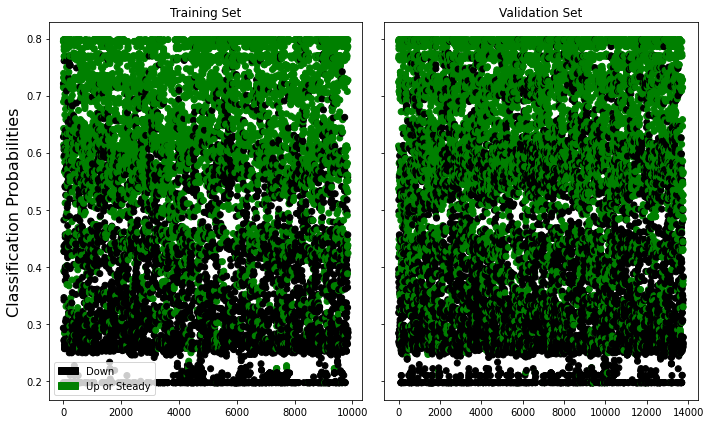

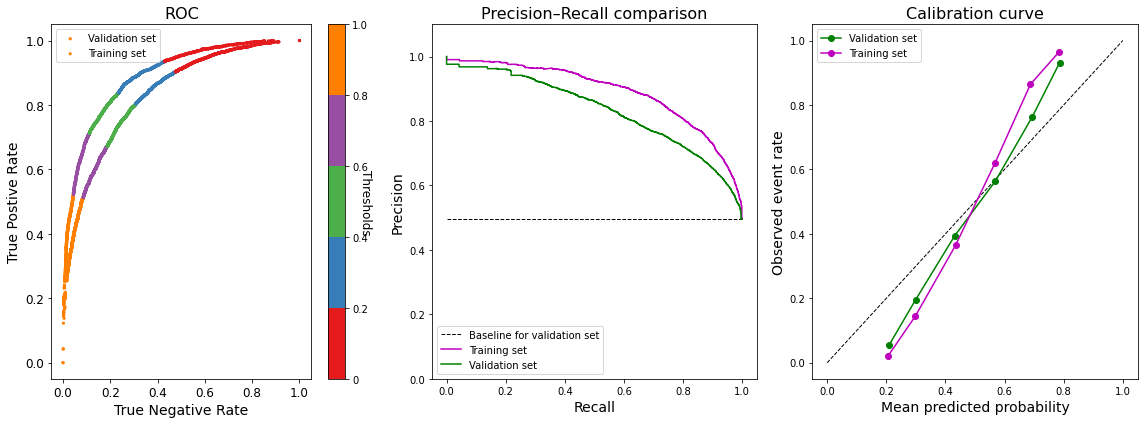

In [48]:
proba_valid_BT = BT.predict_proba(valid_X_clean)[:, 1]
proba_train_BT = BT.predict_proba(train_X_clean)[:, 1]

print("Training Set:")
print("AUC:", roc_auc_score(train_Y_binary, proba_train_BT))
print("LogLoss:", log_loss(train_Y_binary, proba_train_BT))
print("PR AUC:", average_precision_score(train_Y_binary, proba_train_BT))
print("Brier  :", brier_score_loss(train_Y_binary, proba_train_BT))
print("-----"*20)
print("Validation Set:")
print("AUC:", roc_auc_score(valid_Y_binary, proba_valid_BT))
print("LogLoss:", log_loss(valid_Y_binary, proba_valid_BT))
print("PR AUC:", average_precision_score(valid_Y_binary, proba_valid_BT))
print("Brier  :", brier_score_loss(valid_Y_binary, proba_valid_BT))
print("-----"*20)

# Classification Probabilities:
fig1, (axT,axV) = plt.subplots(1,2,figsize=(10,6), sharey=True)
fig2, (axROC,axPR,axC) = plt.subplots(1,3, figsize=(16,6))
valid_color = ['g' if y==1 else 'k' for y in valid_Y_binary]
axV.set_title("Validation Set",fontsize=12)
axV.scatter(range(len(proba_valid_BT)), proba_valid_BT, color=valid_color)

train_color = ['g' if y==1 else 'k' for y in train_Y_binary]
axT.set_ylabel("Classification Probabilities",fontsize=16)
axT.set_title("Training Set",fontsize=12)
axT.scatter(range(len(proba_train_BT)), proba_train_BT, color=train_color)

gr = mpatches.Patch(color='g', label='Up or Steady')
k = mpatches.Patch(color='k', label='Down')
axT.legend(handles=[k,gr])

# ROC:
fprV, tprV, threshV = roc_curve(valid_Y_binary,proba_valid_BT)
threshV[0] = 1
boundV = np.quantile(threshV, [0, .2, .4, .6, .8, 1.0])
norm = mcolors.BoundaryNorm(boundaries=boundV, ncolors=5, clip=True)
sc = axROC.scatter(fprV, tprV, c=threshV, cmap="Set1", norm=norm, s=5, marker='o', label='Validation set')
cb = plt.colorbar(sc, ax=axROC)
cb.set_label("Threshold bins")
cb.ax.set_yticklabels([0, .2, .4, .6, .8, 1.0])
cb.set_label('Thresholds', rotation=270,fontsize=12)

fprT, tprT, threshT = roc_curve(train_Y_binary,proba_train_BT)
threshT[0] = 1
boundT = np.quantile(threshV, [0, .2, .4, .6, .8, 1.0])
norm = mcolors.BoundaryNorm(boundaries=boundT, ncolors=5, clip=True)
sc = axROC.scatter(fprT, tprT, c=threshT, cmap="Set1", norm=norm, s=5, marker='x',label='Training set')

axROC.set_title("ROC",fontsize=16)
axROC.set_ylabel("True Postive Rate",fontsize=14)
axROC.set_xlabel("True Negative Rate",fontsize=14)
axROC.tick_params(axis='both', which='major', labelsize=12)
axROC.legend()

# Precision Recall Curve
precV, recV, thrV = precision_recall_curve(valid_Y_binary, proba_valid_BT)
precT, recT, thrT = precision_recall_curve(train_Y_binary, proba_train_BT)
pos_rate = (np.isclose(valid_Y_binary,1)).mean()
axPR.hlines(pos_rate, 0, 1, linestyles="--",color='k', linewidth=1, label="Baseline for validation set")
axPR.step(recT, precT, where="post", c='m', label='Training set')
axPR.step(recV, precV, where="post", c='g',label='Validation set')
axPR.set_xlabel("Recall",fontsize=14)
axPR.set_ylabel("Precision",fontsize=14)
axPR.set_title("Precision–Recall comparison",fontsize=16)
axPR.set_ylim((0,1.1))
axPR.legend(loc='lower left')

# Calibration Curve
prob_true, prob_pred = calibration_curve(valid_Y_binary, proba_valid_BT, n_bins=8)
prob_true_T, prob_pred_T = calibration_curve(train_Y_binary, proba_train_BT, n_bins=8)
axC.plot([0,1],[0,1],"--", lw=1,c='k')
axC.plot(prob_pred, prob_true, marker="o", c='g', label="Validation set")
axC.plot(prob_pred_T, prob_true_T, marker="o", c='m', label="Training set")
axC.set_xlabel("Mean predicted probability", fontsize=14)
axC.set_ylabel("Observed event rate", fontsize=14)
axC.set_title("Calibration curve", fontsize=16)
axC.legend()


fig1.tight_layout()
fig2.tight_layout()
plt.show()

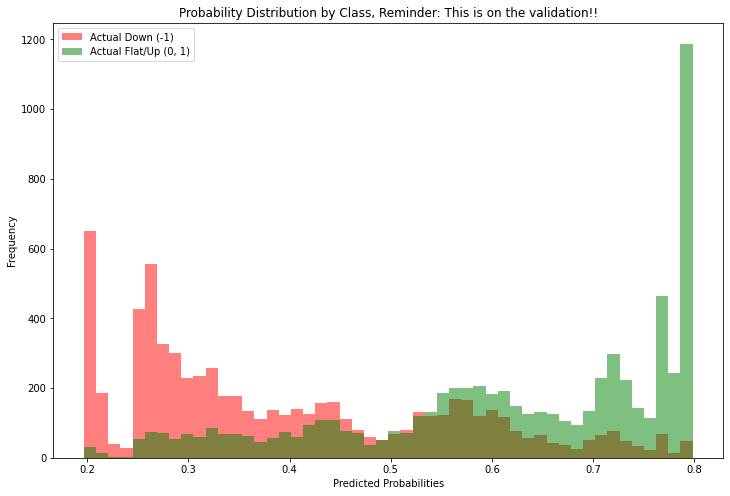

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(proba_valid_BT[valid_Y_binary == 0], bins=50, alpha=0.5, label='Actual Down (-1)', color='red')
ax.hist(proba_valid_BT[valid_Y_binary == 1], bins=50, alpha=0.5, label='Actual Flat/Up (0, 1)', color='green')

ax.set_title('Probability Distribution by Class, Reminder: This is on the validation!!')
ax.set_xlabel('Predicted Probabilities')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

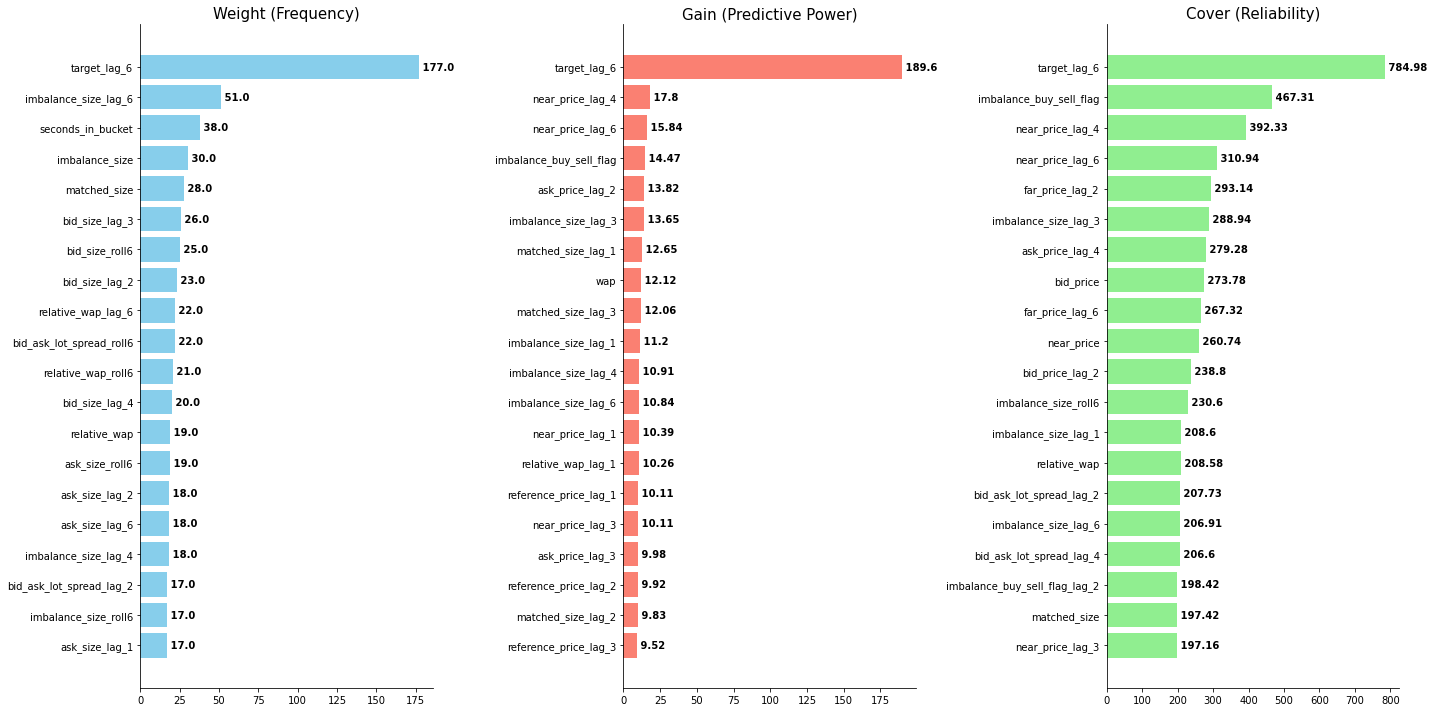

The rest:
                          weight      gain       cover
near_price_roll6             1.0  4.053301   15.560234
bid_price_roll6              4.0  6.304904    9.517413
bid_size_roll6              25.0  5.305105   83.599823
ask_size_roll6              19.0  8.593464  139.195816
wap_roll6                    2.0  7.124996   76.984528
...                          ...       ...         ...
ask_price_lag_6              1.0  7.538826   13.389997
ask_size_lag_6              18.0  6.349958   91.885796
wap_lag_6                   10.0  2.862193  158.924957
relative_wap_lag_6          22.0  6.206332   97.277435
bid_ask_lot_spread_lag_6     4.0  3.601890   23.597073

[77 rows x 3 columns]


In [50]:
booster = BT.get_booster()
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}
importances_df = pd.DataFrame(importances).fillna(0)

# 2. Setup Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
titles = ['Weight (Frequency)', 'Gain (Predictive Power)', 'Cover (Reliability)']

for i, imp_type in enumerate(importance_types):
    # Sort top 20 for this specific metric
    data = importances_df[imp_type].sort_values(ascending=True).tail(20)
    
    # Plot horizontal bars
    bars = axes[i].barh(data.index, data.values, color='skyblue' if i==0 else 'salmon' if i==1 else 'lightgreen')
    
    # Add ROUNDED labels to the end of each bar
    for bar in bars:
        width = bar.get_width()
        axes[i].text(width, bar.get_y() + bar.get_height()/2, 
                     f' {round(width, 2)}',
                     va='center', fontsize=10, fontweight='bold')
    
    axes[i].set_title(titles[i], fontsize=15)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print('The rest:')
print(importances_df[20:])


# WOW!! Classifier doing amaxing work! Let's try regression now

In [57]:
divide = 200
train_data_X = x_new_feats.loc[pdidx[divide:400, :], :].reset_index().drop(columns=['date_id'])
train_data_Y = DY_stock.loc[pdidx[divide:400, :]].values
valid_data_X = x_new_feats.loc[pdidx[400:, :], :].reset_index().drop(columns=['date_id'])
valid_data_Y = DY_stock.loc[pdidx[400:, :]].values


In [58]:
# training on up/steady data
mask_train_up = (~np.isnan(train_data_Y)) & (train_data_Y >= 0)
train_Xup_clean = train_data_X[mask_train_up]
train_Y_up = train_data_Y[mask_train_up]

mask_valid_up = (~np.isnan(valid_data_Y)) & (valid_data_Y >= 0)
valid_Xup_clean = valid_data_X[mask_valid_up]
valid_Y_up = valid_data_Y[mask_valid_up]

In [59]:
#adding classifier probs
train_probs = BT.predict_proba(train_Xup_clean)[:, 1]
valid_probs = BT.predict_proba(valid_Xup_clean)[:, 1]

s_train = pd.Series(train_probs, index=train_Xup_clean.index, name='clf_prob')
s_valid = pd.Series(valid_probs, index=valid_Xup_clean.index, name='clf_prob')

train_X_up = pd.concat([train_Xup_clean, s_train], axis=1)
valid_X_up = pd.concat([valid_Xup_clean, s_valid], axis=1)


In [60]:
# scaling y and replacing lot sizes for logged values
CONSTANT_BUMP = 10_000
eps = 1e-9
train_Y_up_log = np.log(CONSTANT_BUMP*train_Y_up + eps)
valid_Y_up_log = np.log(CONSTANT_BUMP*valid_Y_up + eps)

size_cols = ['bid_size', 'ask_size', 'matched_size', 'imbalance_size', 'bid_ask_lot_spread']
# # Use log1p to handle 0s safely
# x_almost[size_cols] = np.log1p(x_almost[size_cols].clip(lower=0)) 

# train_X_up['bid_size'] = np.log(train_X_up['bid_size'])
# valid_X_up['bid_size'] = np.log(valid_X_up['bid_size'])
train_X_up[size_cols] = np.log(train_X_up[size_cols]) 
valid_X_up[size_cols] = np.log(train_X_up[size_cols]) 
train_X_up[size_cols] = train_X_up[size_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

# train_X_up['ask_size'] = np.log(train_X_up['ask_size'])
# valid_X_up['ask_size'] = np.log(valid_X_up['ask_size'])

# train_X_up['matched_size'] = np.log(train_X_up['matched_size'])
# valid_X_up['matched_size'] = np.log(valid_X_up['matched_size'])

# train_X_up['imbalance_size'] = np.log(train_X_up['imbalance_size'])
# #replace bad values with 0
# train_X_up['imbalance_size'] = train_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

# valid_X_up['imbalance_size'] = np.log(valid_X_up['imbalance_size'])
# #replace bad values with 0
# valid_X_up['imbalance_size'] = valid_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

/home/travis/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/travis/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/travis/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [61]:
# List of columns that represent "sizes" or "lots"
size_cols = ['bid_size', 'ask_size', 'matched_size', 'imbalance_size']

# Construct a list of all columns to transform: base columns + their lags
cols_to_log = []
for col in size_cols:
    cols_to_log.append(col) # Add base
    for i in range(1, 7):   # Add lags 1 through 6
        cols_to_log.append(f"{col}_lag_{i}")

# Apply transformation to both dataframes
for df in [train_X_up, valid_X_up]:
    # Use np.log1p (log(1+x)) to safely handle zeros and avoid -inf
    df[cols_to_log] = np.log(df[cols_to_log])
    
    # Clean up any leftover infinities just in case
    df[cols_to_log] = df[cols_to_log].replace([np.inf, -np.inf], 0).fillna(0)

/home/travis/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/travis/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [62]:
# size_cols = ['bid_size', 'ask_size', 'matched_size', 'imbalance_size']

# for df in [train_X_up, valid_X_up]:
#     roll_df = (
#         df[size_cols]
#         .rolling(window=6)
#         .mean()
#         .reset_index(level=0, drop=True)
#     )
#     roll_df.columns = [f"{c}_roll6" for c in roll_df.columns]
#     df = pd.concat([df, roll_df], axis=1)

### The Regressor<sup><sub><sup>TM</sup></sub></sup>

In [63]:
RT_up = XGBRegressor(
    n_estimators=1_000,
    learning_rate=0.005,           # Ultra-slow to prevent the error jump
    max_depth=3,                   # Very shallow
    min_child_weight=100,          # Only learn very broad, obvious patterns
    objective='reg:squarederror',
    eval_metric='mae',
    base_score=0,#np.mean(train_Y_up_log),
    tree_method='hist',
    early_stopping_rounds=50,
)

### The Regression <sup>&copy;

In [64]:
RT_up.fit(
    train_X_up, 
    train_Y_up_log,
    eval_set=[(valid_X_up, valid_Y_up_log)],
    verbose=200
)

[0]	validation_0-mae:11.23270
[200]	validation_0-mae:4.13871
[400]	validation_0-mae:1.69147
[600]	validation_0-mae:0.99008
[800]	validation_0-mae:0.81922
[999]	validation_0-mae:0.77485


XGBRegressor(base_score=0, booster=None, callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=100, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

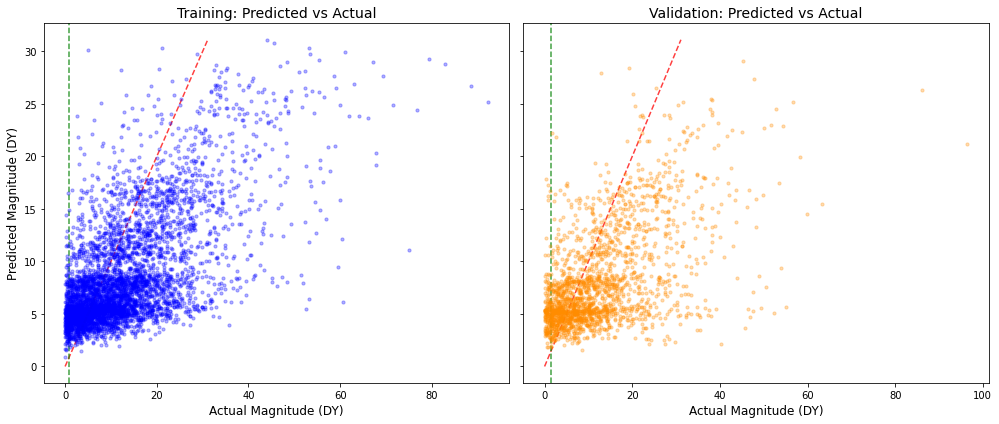

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
preds_train = (np.exp(RT_up.predict(train_X_up)) - eps)/CONSTANT_BUMP
preds_valid = (np.exp(RT_up.predict(valid_X_up)) - eps)/CONSTANT_BUMP
# --- Training Set Plot ---
ax1.scatter(train_Y_up, preds_train, alpha=0.3, color='blue', s=10)
# Add the 'Perfect Prediction' line
# lims = [0, max(train_Y_up.max(), preds_train.max())]
lims = [0, preds_train.max()]
ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax1.axvline(x=preds_train.min(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax1.set_title("Training: Predicted vs Actual", fontsize=14)
ax1.set_xlabel("Actual Magnitude (DY)", fontsize=12)
ax1.set_ylabel("Predicted Magnitude (DY)", fontsize=12)

# --- Validation Set Plot ---
ax2.scatter(valid_Y_up, preds_valid, alpha=0.3, color='darkorange', s=10)
ax2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax2.axvline(x=preds_valid.min(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax2.set_title("Validation: Predicted vs Actual", fontsize=14)
ax2.set_xlabel("Actual Magnitude (DY)", fontsize=12)

plt.tight_layout()

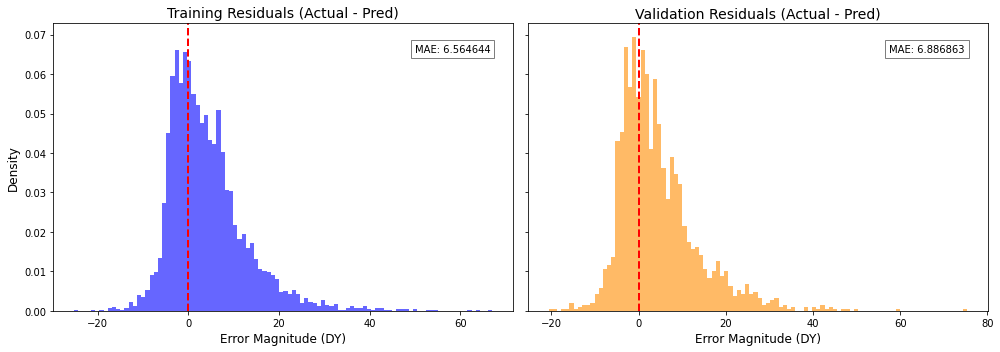

In [66]:
# 1. Calculate the Residuals (Truth - Prediction)
# Positive = Under-predicting | Negative = Over-predicting
resid_train = train_Y_up - preds_train
resid_valid = valid_Y_up - preds_valid

fig, (axH1, axH2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Training Residuals ---
axH1.hist(resid_train, bins=100, color='blue', alpha=0.6, density=True)
axH1.axvline(0, color='red', linestyle='--', lw=2)
axH1.set_title("Training Residuals (Actual - Pred)", fontsize=14)
axH1.set_xlabel("Error Magnitude (DY)", fontsize=12)
axH1.set_ylabel("Density", fontsize=12)

# --- Validation Residuals ---
axH2.hist(resid_valid, bins=100, color='darkorange', alpha=0.6, density=True)
axH2.axvline(0, color='red', linestyle='--', lw=2)
axH2.set_title("Validation Residuals (Actual - Pred)", fontsize=14)
axH2.set_xlabel("Error Magnitude (DY)", fontsize=12)

# Optional: Add a text box with Mean Absolute Error (MAE)
train_mae = np.mean(np.abs(resid_train))
valid_mae = np.mean(np.abs(resid_valid))
axH1.text(0.95, 0.90, f'MAE: {train_mae:.6f}', transform=axH1.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))
axH2.text(0.95, 0.90, f'MAE: {valid_mae:.6f}', transform=axH2.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [67]:
# importance_type = 'gain' # Can also be 'weight' or 'cover'
# scores = RT_up.get_booster().get_score(importance_type=importance_type)

# # Sort and Plot
# sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

# plt.figure(figsize=(10, 8))
# plt.barh(list(sorted_scores.keys())[:15], list(sorted_scores.values())[:15])
# plt.xlabel(f"XGBoost {importance_type.capitalize()}")
# plt.title(f"Top 15 Features by {importance_type.capitalize()}")
# plt.gca().invert_yaxis()
# plt.show()
booster = RT_up.get_booster()

# 2. Extract different importance types
# 'weight': number of times feature is used to split
# 'gain': average gain of splits which use the feature
# 'cover': average coverage of splits which use the feature
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}

# 3. Create a clean DataFrame
importances_df = pd.DataFrame(importances).sort_values(by='gain', ascending=False)
print(importances_df)

                          weight       gain        cover
target_lag_6              1187.0  88.714737  3450.431396
matched_size_lag_3          19.0  35.600048   939.000000
clf_prob                   315.0  27.828665  3549.257080
wap_lag_2                    7.0  25.054609  1253.000000
near_price_roll6             4.0  24.160484  3349.000000
...                          ...        ...          ...
far_price_lag_4             10.0   4.062304  1772.400024
bid_ask_lot_spread_lag_4    17.0   3.178259   799.647034
reference_price_lag_5       34.0   2.840850   873.882324
reference_price_lag_6       21.0   2.502976   342.428558
wap_lag_6                   10.0   1.779549   358.899994

[84 rows x 3 columns]


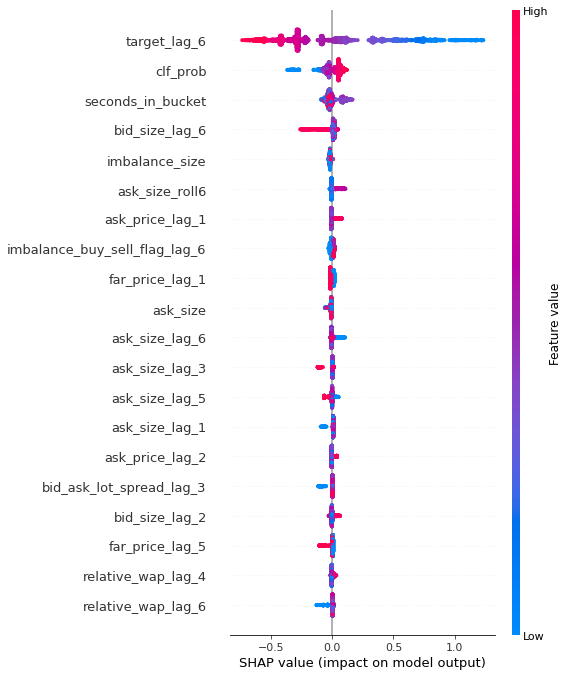

In [68]:
import shap

# Initialize the explainer
explainer = shap.TreeExplainer(RT_up)
shap_values = explainer.shap_values(valid_X_up)

# Summary plot
shap.summary_plot(shap_values, valid_X_up)

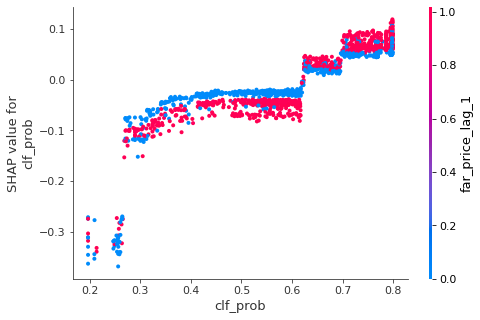

In [69]:
col_idx = valid_X_up.columns.get_loc("clf_prob")
shap.dependence_plot(col_idx, shap_values, valid_X_up)